base on https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2
https://www.tensorflow.org/tutorials/images/segmentation

In [27]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt



In [28]:
path_images = "data/curated_dataset/"
paths_all = glob.glob(os.path.join(path_images, "*.tif"))

paths_exluded = []
for path in paths_all:
    if Image.open(path).size != (224, 224):
        paths_exluded.append(path)
        paths_all.remove(path)



    


In [29]:
map_images = [img for img in paths_all if "map" in img]
mask_images = [mask for mask in paths_all if "mask" in mask]

mask_images.sort()
map_images.sort()



In [30]:
def map_conversion(map):
    map = np.array(Image.open(map))
    map = tf.cast(map, tf.float32) / 255.0
    return map


def mask_conversion(mask):
    mask = (np.array(Image.open(mask).convert("1")) + 1)/2
    mask = np.expand_dims(mask, axis=2)
    mask = tf.cast(mask, tf.float32)
    return mask


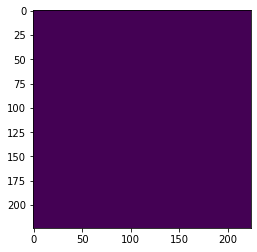

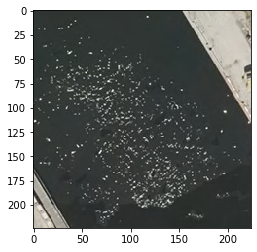

In [31]:
train_images = []
map_train = []
mask_train = []

for map, mask in zip(map_images, mask_images):
    map = map_conversion(map)
    mask = mask_conversion(mask)
    train_images.append((map,  mask))
    map_train.append(map)
    mask_train.append(mask)


plt.imshow(mask_train[25])
plt.show()
plt.close()
plt.imshow(map_train[25], interpolation='nearest')
plt.show()
plt.close()


    


In [32]:
dataset = tf.data.Dataset.from_tensor_slices((map_train, mask_train))
dataset.take(1)


<TakeDataset shapes: ((224, 224, 3), (224, 224, 1)), types: (tf.float32, tf.float32)>

In [33]:
TRAIN_LENGTH = len(dataset)
BATCH_SIZE = 128
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_size = int(0.2 * TRAIN_LENGTH)
test_size = int(0.1 * TRAIN_LENGTH)


train_dataset = dataset.take(train_size)
test_dataset = dataset.take(test_size)





In [34]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(
        mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(
        mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels


In [35]:
train_batches = (
    train_dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))


test_batches = (
    test_dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))


In [36]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


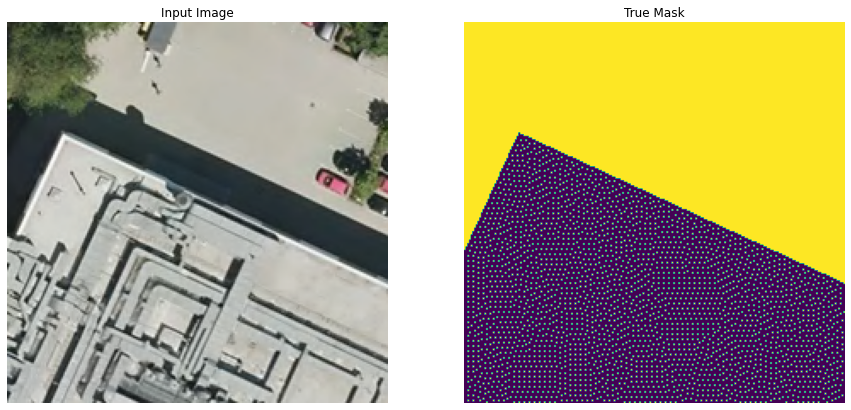

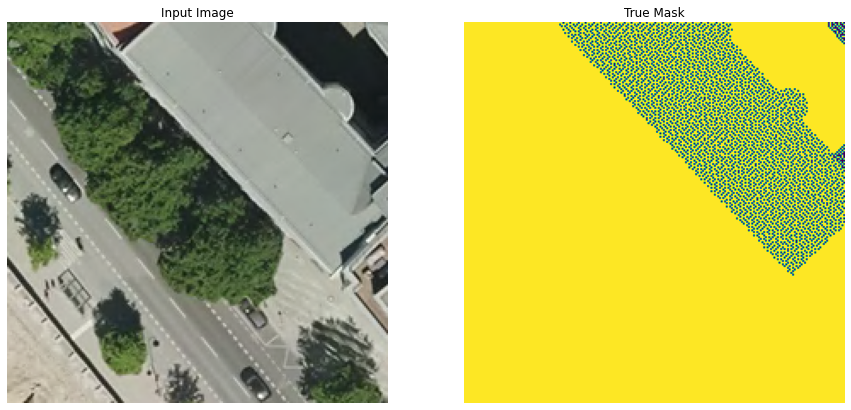

In [37]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])


In [38]:
base_model = tf.keras.applications.MobileNetV2(
                    include_top=True)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(
    name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input,
                            outputs=base_model_outputs)

down_stack.trainable = False


In [39]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


In [40]:
def unet_model(output_channels: int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  # 64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [41]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])


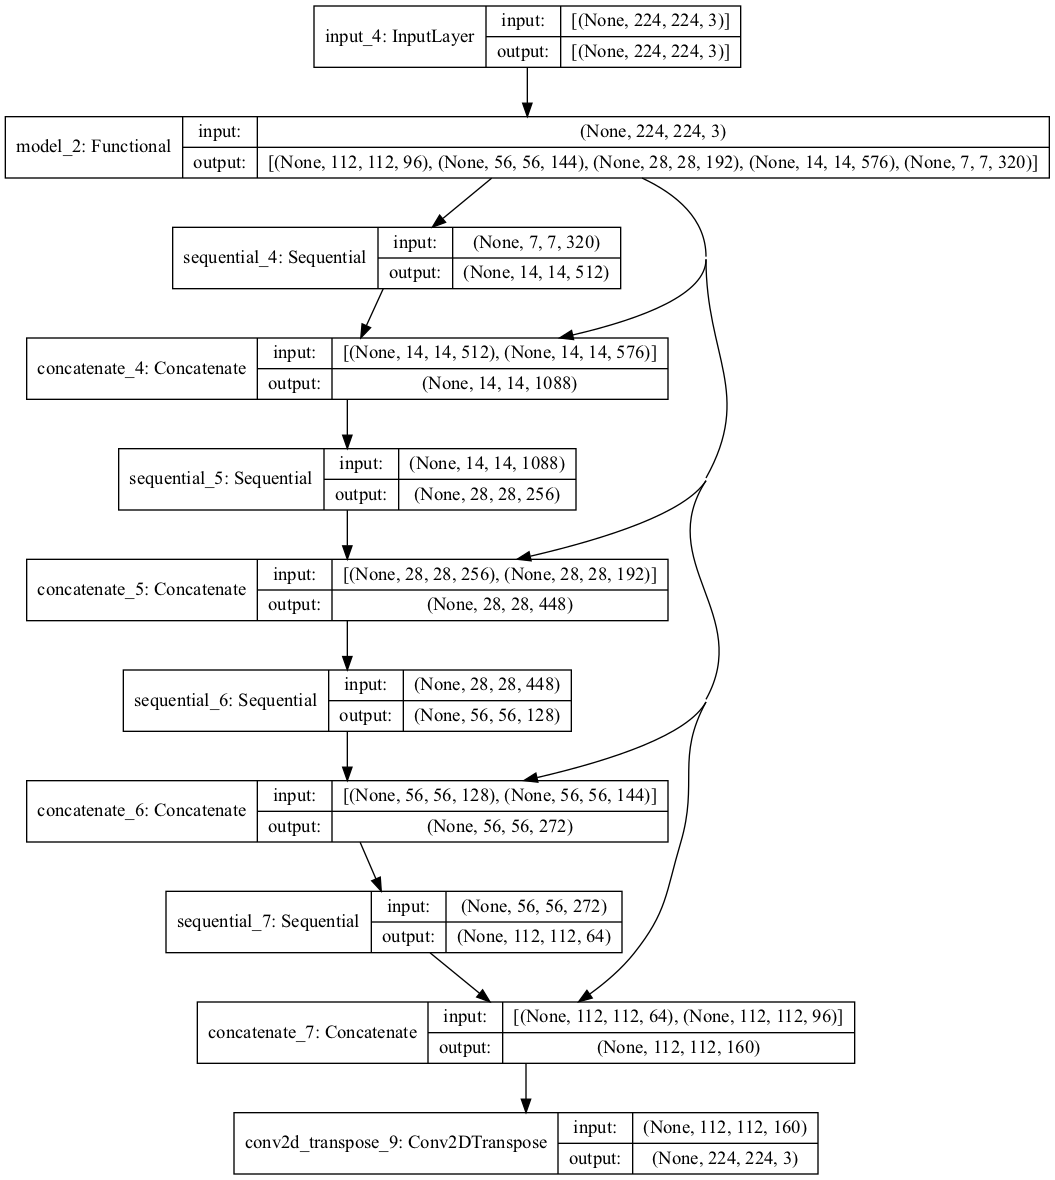

In [42]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [43]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


In [44]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


2021-11-12 13:07:55.520188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


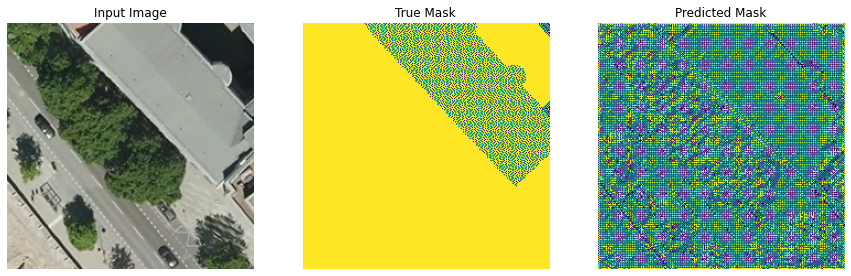

In [45]:
show_predictions()


In [46]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print('\nSample Prediction after epoch {}\n'.format(epoch+1))


In [47]:
from IPython.display import clear_output
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS =  len(test_dataset)
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])


Epoch 1/20


2021-11-12 13:07:56.972378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/9 [============>.................] - ETA: 17s - loss: 0.8898 - accuracy: 0.5914

KeyboardInterrupt: 

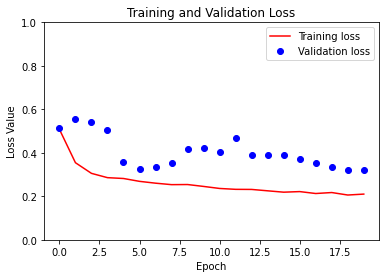

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


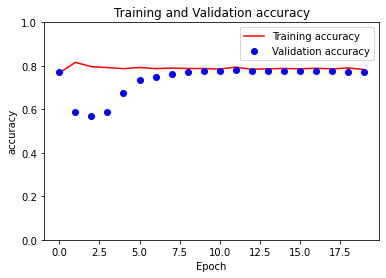

In [ ]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

plt.figure()
plt.plot(model_history.epoch, accuracy, 'r', label='Training accuracy')
plt.plot(model_history.epoch, val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

2021-11-10 01:32:53.024293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


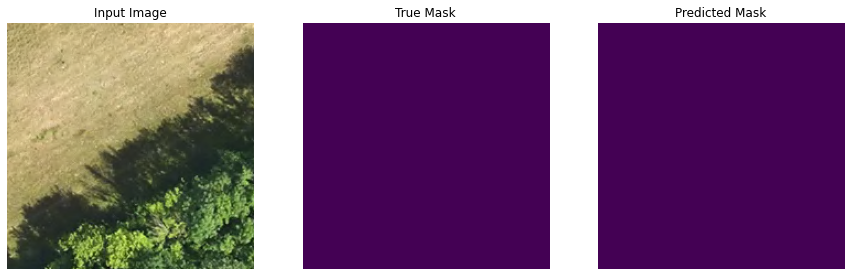

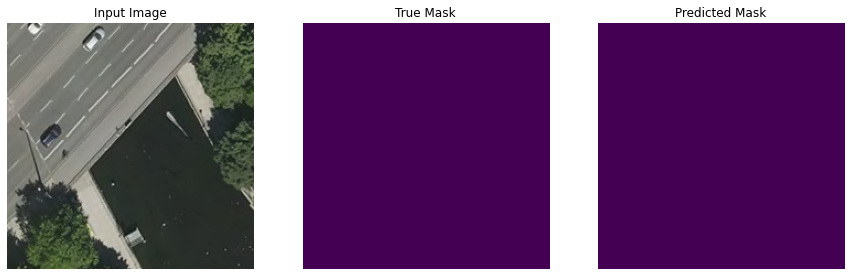

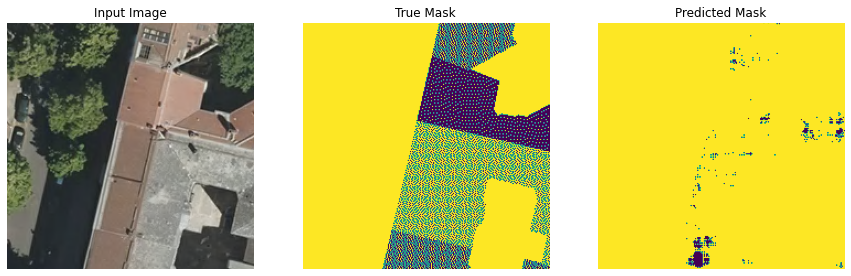

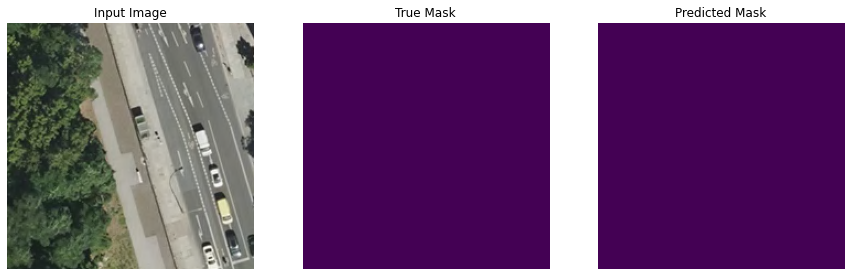

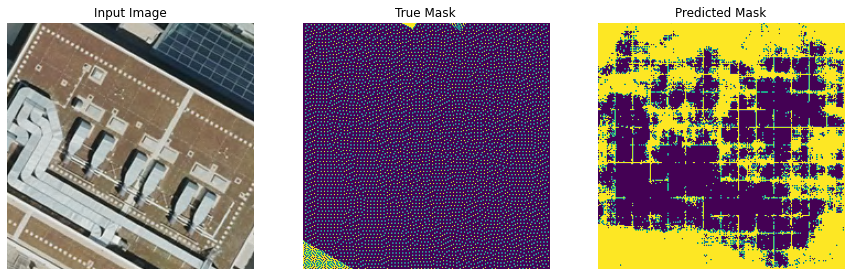

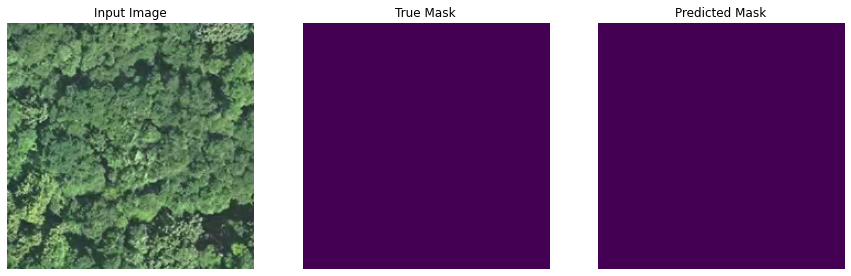

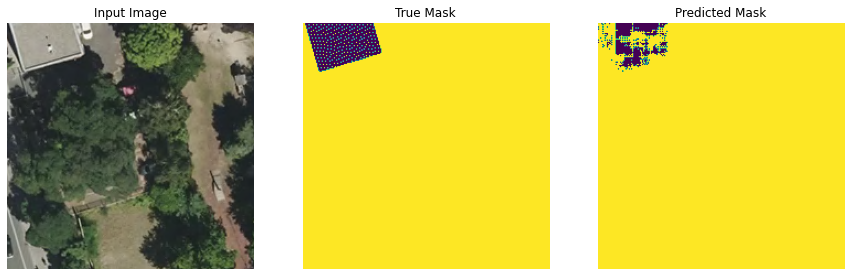

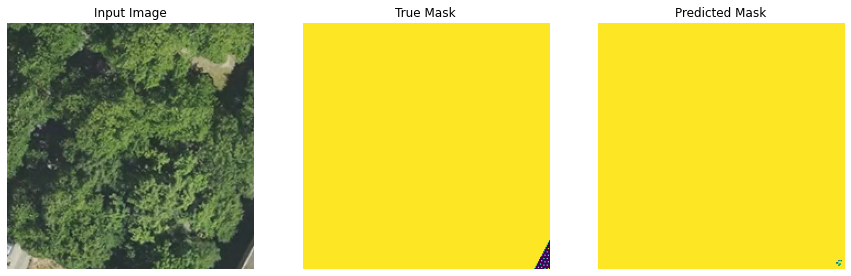

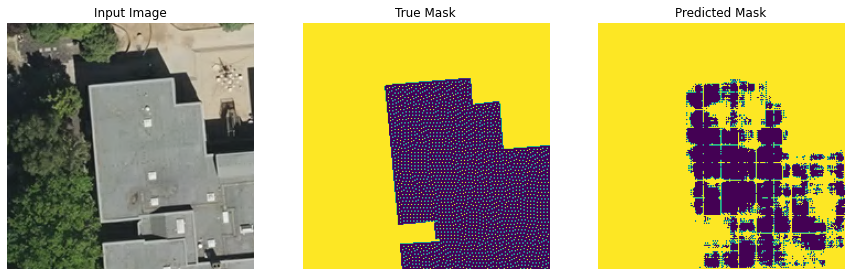

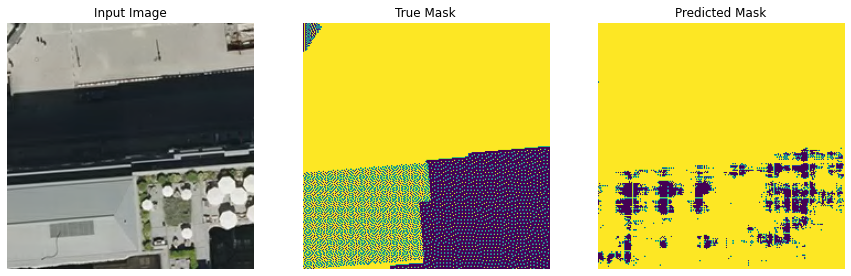

In [ ]:
show_predictions(test_batches, 10)


In [ ]:
TRAIN_LENGTH


1274

In [ ]:
paths_exluded

['curated_dataset/8504-map.8504.tif',
 'curated_dataset/12599-mask.12599.tif',
 'curated_dataset/12149-map.12149.tif',
 'curated_dataset/12059-map.12059.tif',
 'curated_dataset/12059-mask.12059.tif',
 'curated_dataset/12599-map.12599.tif',
 'curated_dataset/4004-map.4004.tif',
 'curated_dataset/10979-map.10979.tif',
 'curated_dataset/4004-mask.4004.tif',
 'curated_dataset/12149-mask.12149.tif',
 'curated_dataset/8504-mask.8504.tif',
 'curated_dataset/10979-mask.10979.tif']